In [1]:
#reloads any packages before importing
%load_ext autoreload
%autoreload 2

# Numpy imports:
import numpy as np

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

#import cv2

# for extracting filenames
import glob

# skimage submodules we need
import skimage.io
import skimage.measure
import skimage.filters
import skimage.exposure
import skimage.morphology
from skimage.registration import phase_cross_correlation

#Matplotlib imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#for DataFrames
import pandas as pd

#To interact with the operating system
import os

#For status bar 
from tqdm.notebook import tqdm as tqdm

#Custom packages
import atp_cal

#RP plotting style
atp_cal.pboc_style_mpl()
# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'


## Data locations

In [6]:
#This should not change between experiments:
datapath = '../../data/atp_cal'

#This varies between experiments. 
datafolder = '2023-12-16_A81D_Cal' #EDIT THIS EVERY TIME

# bound Images
included_bound = '*uM*/*Pos*/*405*.tif' #EDIT THIS EVERY TIME
bound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_bound))

# unbound Images
included_unbound = '*uM*/*Pos*/*480*.tif' #EDIT THIS EVERY TIME
unbound_files = np.sort(glob.glob(datapath+'/'+datafolder+'/'+included_unbound))

#Find the ATP concentrations of each image
ATPconc_unsrt=[]
for i, file in enumerate(unbound_files):
    conc = int(file.split('/')[5].split('_')[0].split('uM')[0]) #EDIT THIS EVERY TIME
    ATPconc_unsrt.append(conc)
ATPconc_unsrt = np.array(ATPconc_unsrt)

#Find the indeces to sort the ATP concentrations and reorder
sorted_indices = np.argsort(ATPconc_unsrt)
ATPconc=ATPconc_unsrt[sorted_indices]

#Read in images and save as array:
bound_array_unsrt = atp_cal.file_to_image(bound_files)
unbound_array_unsrt = atp_cal.file_to_image(unbound_files)

#Sort the images
bound_array=bound_array_unsrt[sorted_indices]
unbound_array=unbound_array_unsrt[sorted_indices]

# Define the zero concentration image (DO EVERY TIME):
bound_zero = np.average(bound_array[np.where(ATPconc==0)], axis=0)
unbound_zero = np.average(unbound_array[np.where(ATPconc==0)], axis=0)

## Define background
Pick one of the following 3 methods

Method 1:
Uniformly subtract a single value

Method 2: Use a camera off image

In [7]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_files = np.sort(glob.glob(file_path_dark))
dark_ims = atp_cal.file_to_image(dark_files)
dark_avg = np.average(dark_ims, axis=0)

bound_bg = np.copy(dark_avg)
unbound_bg = np.copy(dark_avg)

Method 3: Use a no ATP and no ATeam image

## Subtract Background

In [27]:
bound_bs = bound_array - bound_bg
unbound_bs = unbound_array - unbound_bg

unbound_bs[unbound_bs<0] = 0
bound_bs[unbound_bs<0] = 0

bound_zero_bs = bound_zero - bound_bg
unbound_zero_bs = unbound_zero - unbound_bg

## Crop

In [32]:
#Creates crop window in pixels
win_size=400 # half length of the square crop sides
im_shape = bound_array[0].shape
centy, centx = im_shape[0]//2, im_shape[1]//2 #find center
ymin= centy - win_size
ymax= centy + win_size
xmin= centx - win_size
xmax= centx + win_size
crop_win=np.s_[ymin:ymax, xmin:xmax] #for single ims
crop_arrwin=np.s_[:,  ymin:ymax, xmin:xmax] #for arrays

## Correct for uneven illumination

In [18]:
def fit_bivariate_quadratic(image):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    image (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Get image dimensions
    M, N = image.shape

    # Create a meshgrid of coordinates
    i = np.arange(M)
    j = np.arange(N)
    I, J = np.meshgrid(i, j, indexing='ij')

    # Flatten the matrices for the least squares fitting
    I_flat = I.flatten()
    J_flat = J.flatten()
    Z_flat = image.flatten()

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly(image):
    """ Evaluates best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic(image);
    I, J = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

def BivPolyNormMat(image):
    """Finds Normalization Matrix"""
    im_biv = evaluateBivPoly(image)
    alpha = np.nanmean(im_biv)/im_biv
    return alpha

Compute Normalization Matrices

In [33]:
norm_mat_bound = BivPolyNormMat(bound_zero_bs[crop_win])
norm_mat_unbound = BivPolyNormMat(unbound_zero_bs[crop_win])

just in case you want to show that the norm matrix for the averaged zeros is pretty much the same as the norm mat for the individual ims

In [49]:
testnorm = np.zeros((4, 2*win_size, 2*win_size))
for i, im in enumerate(bound_bs[np.where(ATPconc==0)]):
    testnorm[i]+=BivPolyNormMat(im[crop_win])
print(f'the bound norm matrix is the same within a range of {round(np.min(testnorm/norm_mat_bound)-1,4)} to {round(np.max(testnorm/norm_mat_bound)-1, 4)}')


the bound norm matrix is the same within a range of -0.0042 to 0.0044


Apply normalization Matrices

In [50]:
#Normalize all the calibration images by multiplying by the normalization matrix
bound_norm = bound_bs[crop_arrwin]*norm_mat_bound
unbound_norm = unbound_bs[crop_arrwin]*norm_mat_unbound

## Take the Ratio

In [51]:
ratio_im = bound_norm/unbound_norm
ratio_im[np.where(ratio_im==np.inf)] = np.nan
ratio_calavg = np.nanmean(ratio_im, axis=(1,2))

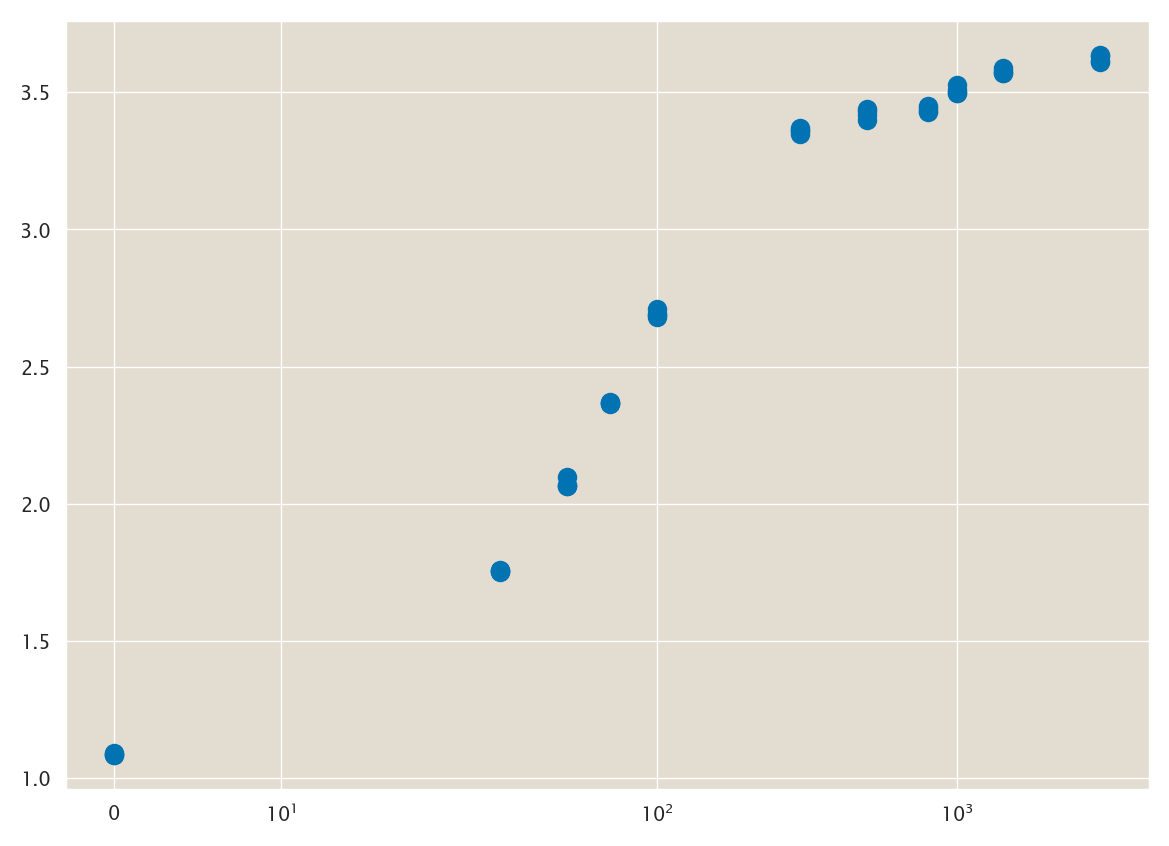

In [64]:
plt.scatter(ATPconc, ratio_calavg)
plt.xscale('symlog', linthresh=20)#, linscale=0.5)

## Fit to a Michaelis_Menten Curve

In [67]:
#Langmuir equation
def ATeam_Hill(conc, a, b, c):
    """
    Given a concentration value, this function returns an intensity value based on the Hill function given
    in Immamura et. al (ATeam paper)
    Parameters
    conc = 1D array of concentrations
    a, b, c, d parameters of the function
    
    Returns
    A 1D array of intensities corresponding to the given concentrations
    """
    
    
    
    return (((b-c)*(conc/a)/(1+(conc/a)))+c)



#Curve-fit to the Langmuir curve
def ATeam_Hill_curve_fit(conc, calavg, maxconc, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit to fit data to a Langmuir curve
    
    Parameters
    conc = 1D array of concentrations
    calavg = 1D array of average intensity values of data
    maxconc = scalar Maximum concentration of data taken
    p0 = 1D list with 3 entries of parameter guesses for a, b, and c in the Hill function
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(ATeam_Hill, 
                                 conc, 
                                 calavg, 
                                 p0, 
                                 bounds = (np.zeros(3), np.ones([3])*np.inf))

    #stores the new function information according to the coefficients given by curve-fit() function 
    xvals=np.linspace(0,maxconc,maxconc)
    curve = ATeam_Hill(xvals, param[0], param[1], param[2])
    
    return param, curve, xvals

[70.23295266  3.71809725  1.03669534]


Text(0.5, 1.0, 'ATP Calibration Curve')

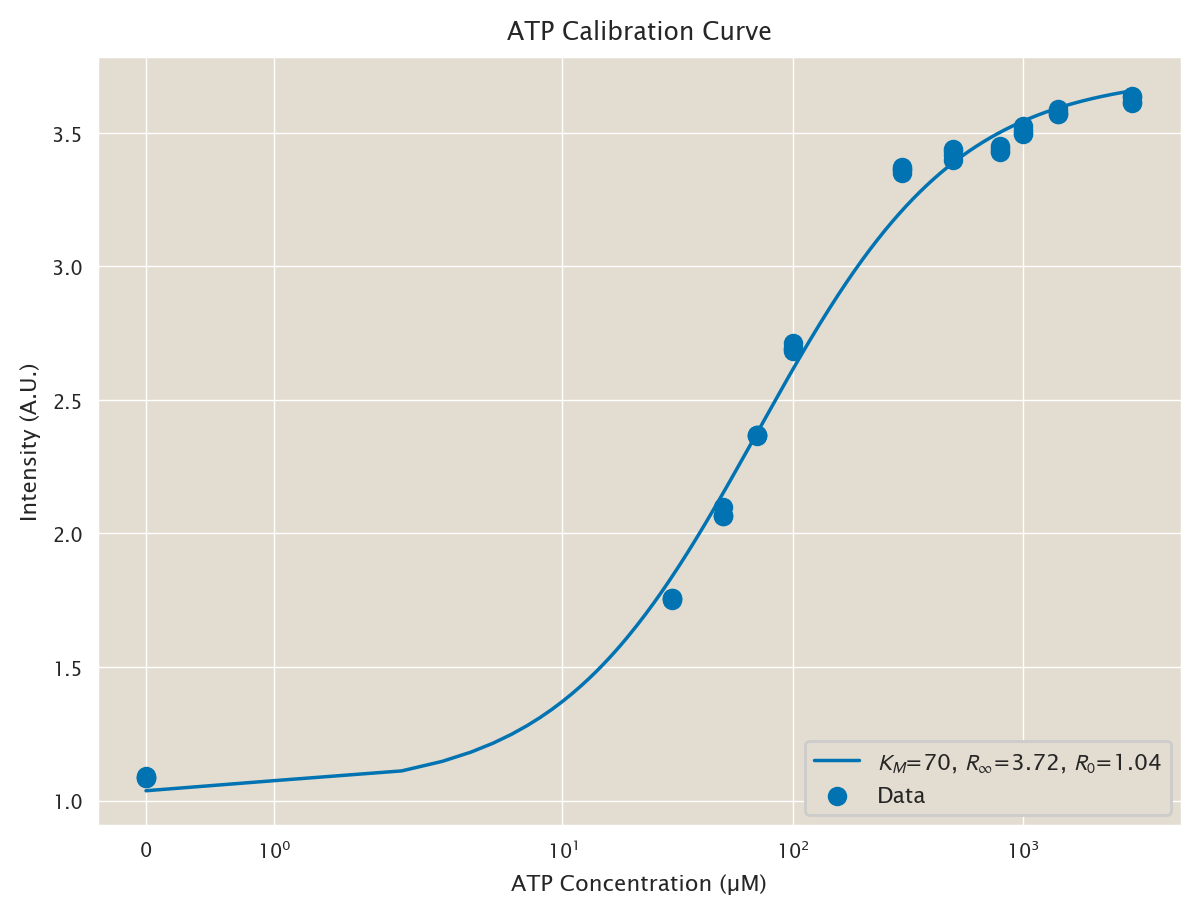

In [76]:
params, curve, xvals = ATeam_Hill_curve_fit(ATPconc[:], ratio_calavg[:], np.max(ATPconc), [300, 1, 0.5])
print(params)

plt.scatter(ATPconc[:], ratio_calavg[:], label = 'Data')
plt.xscale('symlog')
plt.plot(xvals, curve, label=f'$K_M$={round(params[0])}, $R_\infty$={round(params[1],2)}, $R_0$={round(params[2],2)}')
plt.legend(loc = 'lower right')
plt.xlabel('ATP Concentration (µM)')
plt.ylabel('Intensity (A.U.)')
plt.title('ATP Calibration Curve')

## Save